# Sports Action Recognition Using CNN-RNN Architecture with Transfer Learning on `UCF101 10 Sports actions`

## Dependencies

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, top_k_accuracy_score, classification_report, confusion_matrix

import imageio
import cv2
from IPython.display import Image

import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm

import kagglehub

/opt/homebrew/Caskroom/miniforge/base/envs/ai_ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Loading

Download latest version of the ucf101-action-recognition dataset from Kaggle

In [2]:
path = kagglehub.dataset_download("matthewjansen/ucf101-action-recognition")

In [3]:
print("Path to dataset files: \n", path)
print("\nFiles in dataset directory:\n", os.listdir(path))

Path to dataset files: 
 /Users/barnabasukwuani/.cache/kagglehub/datasets/matthewjansen/ucf101-action-recognition/versions/4

Files in dataset directory:
 ['test', 'val.csv', 'test.csv', 'train', 'train.csv', 'val']


**Class Definition**

In [4]:
sports_actions = [
    "SkyDiving",
    "Biking",
    "HorseRace",
    "Surfing",
    "TennisSwing",
    "Punch",
    "Basketball",
    "JumpRope",
    "Archery",
    "Skiing",
]

Utility to transform video paths

In [5]:
def load_dataset(dataset_type):
    dataset_path = os.path.join(path, f"{dataset_type}.csv")
    dataset = pd.read_csv(dataset_path)

    # Filter dataset to only include the specified sports actions
    filtered_dataset = dataset[dataset["label"].isin(sports_actions)]

    return pd.DataFrame(
        {
            "label": filtered_dataset["label"],
            "video_name": filtered_dataset["clip_name"],
            "rel_path": filtered_dataset["clip_path"],
            "video_path": filtered_dataset["clip_path"].apply(lambda x: f"{path}{x}"),
        }
    )

Load the train and test datasets

In [6]:
train_df = load_dataset("train")
val_df = load_dataset("val")
test_df = load_dataset("test")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for validation: {len(val_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 1128
Total videos for validation: 189
Total videos for testing: 192


In [7]:
print("Number of unique classes in training set: ", len(train_df["label"].unique()))
print("Number of unique classes in validation set: ", len(val_df["label"].unique()))
print("Number of unique classes in test set: ", len(test_df["label"].unique()))

print("\nLabels: \n", train_df["label"].unique())

Number of unique classes in training set:  10
Number of unique classes in validation set:  10
Number of unique classes in test set:  10

Labels: 
 ['SkyDiving' 'TennisSwing' 'Skiing' 'Punch' 'Archery' 'JumpRope'
 'Basketball' 'Biking' 'HorseRace' 'Surfing']


In [8]:
train_df.sample(10)

,label,video_name,rel_path,video_path
2997,Archery,v_Archery_g10_c05,/train/Archery/v_Archery_g10_c05.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
9027,HorseRace,v_HorseRace_g03_c04,/train/HorseRace/v_HorseRace_g03_c04.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
148,SkyDiving,v_SkyDiving_g08_c02,/train/SkyDiving/v_SkyDiving_g08_c02.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
9078,HorseRace,v_HorseRace_g07_c01,/train/HorseRace/v_HorseRace_g07_c01.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
2895,Punch,v_Punch_g25_c04,/train/Punch/v_Punch_g25_c04.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
5240,Basketball,v_BasketballDunk_g09_c01,/train/Basketball/v_BasketballDunk_g09_c01.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
2852,Punch,v_Punch_g01_c05,/train/Punch/v_Punch_g01_c05.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
9757,Surfing,v_Surfing_g20_c04,/train/Surfing/v_Surfing_g20_c04.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
2912,Punch,v_Punch_g18_c07,/train/Punch/v_Punch_g18_c07.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...
1869,Skiing,v_Skiing_g20_c01,/train/Skiing/v_Skiing_g20_c01.avi,/Users/barnabasukwuani/.cache/kagglehub/datase...


## Configs & Hyperparameters

In [ ]:
MODEL_NAME = "cnn_rnn_ucf101_10c_tl_v10_200f_EfficientNetV2M"
MODEL_BASE_PATH = f"../models/{MODEL_NAME}"
DATA_FILE_BASE = "../data/preprocessed_200f_EfficientNetV2M"

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 120
LEARNING_RATE = 1e-4

MAX_SEQ_LENGTH = 200 # Chosen according to distribution of video lengths below
NUM_FEATURES = 1280

## Video Data Explorartion

#### Label Encoding

Encode the class labels as integers using the Keras StringLookup layer

In [10]:
np.unique(train_df["label"])

array(['Archery', 'Basketball', 'Biking', 'HorseRace', 'JumpRope',
       'Punch', 'Skiing', 'SkyDiving', 'Surfing', 'TennisSwing'],
      dtype=object)

In [11]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=sports_actions)

class_vocab = label_processor.get_vocabulary()

print(f"Vocabulary: {class_vocab}")
print(f"Number of classes: {len(class_vocab)}")

Vocabulary: ['SkyDiving', 'Biking', 'HorseRace', 'Surfing', 'TennisSwing', 'Punch', 'Basketball', 'JumpRope', 'Archery', 'Skiing']
Number of classes: 10


Utility to convert string labels to one-hot encoded format

In [12]:
def encode_labels(labels: np.ndarray) -> np.ndarray:
    integer_labels = keras.ops.convert_to_numpy(label_processor(labels[..., None]))
    return keras.utils.to_categorical(integer_labels, num_classes=len(class_vocab))

#### Review video category distribution

Combined average number of videos per class:
             Train  Validation  Test  Average
label                                        
Archery        108          18    19       48
Basketball     198          33    34       88
Biking         100          17    17       45
HorseRace       93          15    16       41
JumpRope       108          18    18       48
Punch          120          20    20       53
Skiing         101          17    17       45
SkyDiving       82          14    14       37
Surfing         94          16    16       42
TennisSwing    124          21    21       55


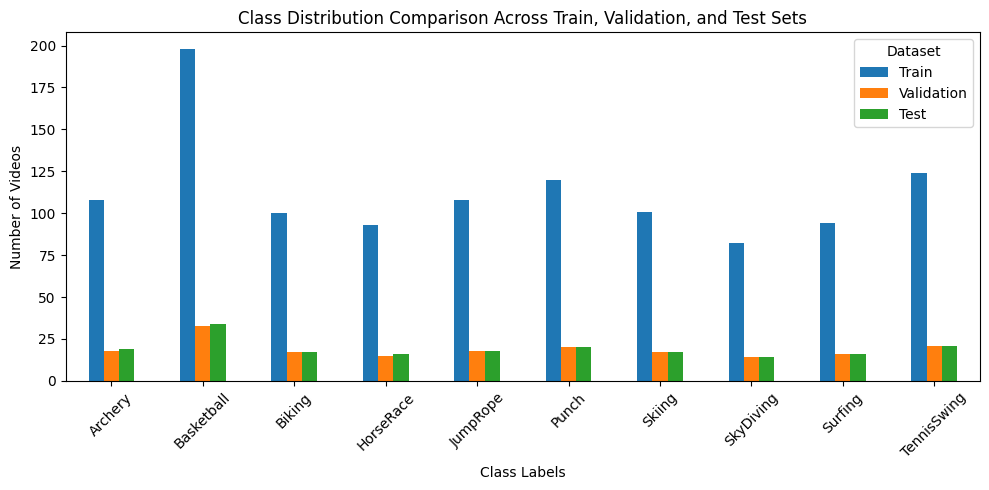

In [13]:
def review_class_distribution(dataset, dataset_name):
    class_counts = dataset["label"].value_counts()
    return class_counts

# Get class distributions for each dataset
train_class_counts = review_class_distribution(train_df, "Train")
val_class_counts = review_class_distribution(val_df, "Validation")
test_class_counts = review_class_distribution(test_df, "Test")

# Create DataFrame for distribution and calculate average
distribution_df = pd.DataFrame({
    "Train": train_class_counts,
    "Validation": val_class_counts,
    "Test": test_class_counts
}).fillna(0)

distribution_df["Average"] = distribution_df.mean(axis=1).round().astype(int)
print("Combined average number of videos per class:")
print(distribution_df)

# Plot the distribution
plot_distribution_df = distribution_df.drop(columns="Average")
plot_distribution_df.plot(kind="bar", figsize=(10, 5))
plt.title("Class Distribution Comparison Across Train, Validation, and Test Sets")
plt.xlabel("Class Labels")
plt.ylabel("Number of Videos")
plt.legend(title="Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Review Video frame distribution 

Count the number of frames for each video

In [14]:
def count_frames_per_video(video_paths):
    frame_counts = []

    for video_path in video_paths: 
        cap = cv2.VideoCapture(video_path)
        count = 0
        
        while cap.isOpened():
            ret, _ = cap.read()
            if not ret:
                break
            count += 1
        cap.release()
        frame_counts.append(count)

    return frame_counts

In [15]:
def visualize_frame_distribution(frame_counts):
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=frame_counts)
    plt.title("Violin Plot of Frame Counts per Video")
    plt.xlabel("Number of Frames")
    plt.xlabel("Number of Frames")
    plt.show()

In [16]:
frame_counts = count_frames_per_video(train_df["video_path"].values)

Distribution of the frames

In [17]:
print(f"Minimum number of frames per video: {np.min(frame_counts)}")
print(f"Maximum number of frames per video: {np.max(frame_counts)}")
print(f"Average number of frames per video: {np.mean(frame_counts):.2f}")
print(f"Median number of frames per video: {np.median(frame_counts)}")
print(f"Standard deviation of frames per video: {np.std(frame_counts):.2f}")

Minimum number of frames per video: 30
Maximum number of frames per video: 623
Average number of frames per video: 214.59
Median number of frames per video: 200.0
Standard deviation of frames per video: 115.26


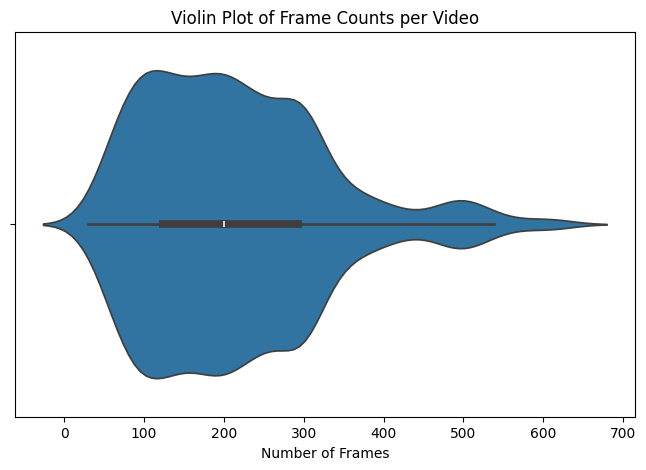

In [18]:
visualize_frame_distribution(frame_counts)

## Video Data Preprocessing

#### Video preprocessing utilities

 Function to resize the video frames to a square shape without distorting their content

In [19]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]  # Get the height (y) and width (x) of the image
    min_dim = min(y, x)       # Find the smallest dimension (either height or width)
    start_x = (x // 2) - (min_dim // 2)  # Calculate the horizontal starting point for the crop
    start_y = (y // 2) - (min_dim // 2)  # Calculate the vertical starting point for the crop

    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]  # Return the cropped square

Crop,resize, and reorder color channels

In [20]:
def load_and_preprocess_video(video_path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):    
    cap = cv2.VideoCapture(video_path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame) # Crop center square
            frame = cv2.resize(frame, resize) # Resize the image (In this case to 224x224)
            frame = frame[:, :, [2, 1, 0]] # Reorder the color channels from OpenCV BGR to RGB
            frame = frame / 255.0
            
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
   
    return np.array(frames)

#### Feature Extraction with Transfer Learning

Using a pre-trained network to extract meaningful features from the extracted frames
- The Inception-ResNet V2 model without the top layer
- Pretrained on ImageNet-1k dataset

In [31]:
def build_feature_extractor():
    feature_extractor = tf.keras.applications.efficientnet_v2.EfficientNetV2M(
        weights="imagenet",
        include_top=False,
        pooling="avg",  # Global average pooling to reduce the output to a vector
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    
    inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
    # Preprocess the input using EfficientNetV2 preprocessing function
    preprocessed = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    
    # Extract features
    features = feature_extractor(preprocessed)
    
    return tf.keras.Model(inputs, features, name="feature_extractor")

In [32]:
feature_extractor = build_feature_extractor()

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


Helper function to create masks and features for a single video
- `frame_features` will contain extracted features per frame
- `frame_masks` will contain booleans denoting if a timestep/frame is padded or not

In [23]:
def create_video_features_and_mask(frames):
    mask = np.zeros((MAX_SEQ_LENGTH,), dtype="bool")
    features = np.zeros((MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Extract features for each frame
    for i, frame in enumerate(frames[:MAX_SEQ_LENGTH]):
        feature = feature_extractor(tf.expand_dims(frame, 0))
        features[i] = feature
        mask[i] = True  # Mark this frame as valid in the mask

    return features, mask

#### Video frames preprocessing and saving

Save features and mask to disk

In [24]:
def save_features_masks_and_labels(features, masks, labels, save_path, dataset_type):
    np.savez_compressed(save_path, features=features, masks=masks, labels=labels)
    print(f"Saved {dataset_type} features, masks, and labels to {save_path}")

Load a batch of videos and process them

In [25]:
def load_and_process_batch(video_paths, dataset_type):
    start_time = time.time()

    features_list = []
    masks_list = []

    for video_path in video_paths:
        frames = load_and_preprocess_video(video_path)
        features, mask = create_video_features_and_mask(frames)

        features_list.append(features)
        masks_list.append(mask)

    # Stack all features and masks for model input
    features_batch = np.stack(features_list)
    masks_batch = np.stack(masks_list)

    elapsed = time.time() - start_time
    print(f"Processed {len(video_paths)} {dataset_type} videos in {elapsed:.2f}s")

    return features_batch, masks_batch

Preprocess entire dataset and save to disk for faster future loading

In [26]:
def preprocess_dataset_with_resume(data_df, save_path, dataset_type):
    CHUNK_SIZE = 64
    total_length = len(data_df)
    processed_chunks_file = save_path.replace(".npy", f"_progress.npy")

    # Load progress
    processed_chunks = np.load(processed_chunks_file).tolist() if os.path.exists(processed_chunks_file) else []

    # Initialize lists for storing processed data
    all_features, all_masks, all_labels = [], [], []

    # Load already processed data if exists
    if os.path.exists(save_path):
        data = np.load(save_path)
        all_features = [data["features"]]
        all_masks = [data["masks"]]
        all_labels = [data["labels"]]

    with tqdm(total=(total_length // CHUNK_SIZE) + 1, desc="Processing dataset", colour="green") as pbar:
        pbar.update(len(processed_chunks))  # Update progress based on already processed chunks

        for i in range(0, total_length, CHUNK_SIZE):
            if i in processed_chunks:
                continue  # Skip already processed chunks

            chunk_df = data_df.iloc[i:i + CHUNK_SIZE]
            labels = keras.ops.convert_to_numpy(label_processor(chunk_df["label"].values[..., None]))
            features, masks = load_and_process_batch(chunk_df["video_path"].tolist(), dataset_type)

            # Append new data
            all_features.append(features)
            all_masks.append(masks)
            all_labels.append(labels)

            # Save progress and current data state
            processed_chunks.append(i)
            np.save(processed_chunks_file, processed_chunks)
            save_features_masks_and_labels(
                np.concatenate(all_features, axis=0),
                np.concatenate(all_masks, axis=0),
                np.concatenate(all_labels, axis=0),
                save_path,
                dataset_type
            )

            pbar.update(1)  # Increment progress bar

    # Clean up progress file after completion
    os.remove(processed_chunks_file) if os.path.exists(processed_chunks_file) else None

    return (
        np.concatenate(all_features, axis=0),
        np.concatenate(all_masks, axis=0),
        np.concatenate(all_labels, axis=0),
    )

Save features and mask to disk

In [27]:
def save_features_masks_and_labels(features, masks, labels, save_path, dataset_type):
    np.savez_compressed(save_path, features=features, masks=masks, labels=labels)
    print(f"Saved {dataset_type} features, masks, and labels to {save_path}")

Load the dataset from a saved file if it exists, otherwise process it, save it, and load it.

In [28]:
def load_or_preprocess_dataset(data_df, save_path, dataset_type):
    if os.path.exists(save_path):
        print(f"Loading dataset from {save_path}")
        data = np.load(save_path)
        features, masks, labels = data["features"], data["masks"], data["labels"]
                    
    else:
        print(f"Saved {dataset_type} dataset not found. Processing dataset...")
        features, masks, labels = preprocess_dataset_with_resume(data_df, save_path, dataset_type)
        save_features_masks_and_labels(features, masks, labels, save_path, dataset_type)
        
    return features, masks, labels

### Load datafiles

In [29]:
train_save_path = f"{DATA_FILE_BASE}/train_features_masks_labels.npz"
val_save_path = f"{DATA_FILE_BASE}/val_features_masks_labels.npz"
test_save_path = f"{DATA_FILE_BASE}/test_features_masks_labels.npz"

Extract the frame features, feature masks and labels for the `train` set

In [30]:
train_features, train_masks, train_labels = load_or_preprocess_dataset(
    train_df,
    train_save_path,
    "Training",
)

Saved Training dataset not found. Processing dataset...


Processing dataset:   0%|          | 0/18 [58:23<?, ?it/s]


KeyboardInterrupt: 

Extract the frame features, feature masks and labels for the `validation` set

In [ ]:
val_features, val_masks, val_labels = load_or_preprocess_dataset(
    val_df,
    val_save_path,
    "Validation",
)

Extract the frame features, feature masks and labels for the `test` set

In [ ]:
test_features, test_masks, test_labels = load_or_preprocess_dataset(
    test_df,
    test_save_path,
    "Test",
)

Review dataset size

In [ ]:
print("════════════════════ TRAIN SET ════════════════════\n")

# Train set
total_samples, frame_count, num_of_features = train_features.shape
print(f"""Frame features in train set: {train_features.shape} 
    → {total_samples} samples
    → {frame_count} frames per video
    → {num_of_features} features per frame
""")

total_samples, mask_count = train_masks.shape
print(f"""Frame masks in train set: {train_masks.shape} 
    → {total_samples} samples
    → {mask_count} masks per video
""")
print(f"Labels in train set: {train_labels.shape} → {train_labels.shape[0]} samples\n")

print("════════════════════ VALIDATION SET ════════════════════\n")

# Validation set
print(f"Frame features in validation set: {val_features.shape}")
print(f"Frame masks in validation set: {val_masks.shape}")
print(f"Labels in validation set: {val_labels.shape} → {val_labels.shape[0]} samples\n")

print("════════════════════ TEST SET ════════════════════\n")

# Test set
print(f"Frame features in test set: {test_features.shape}")
print(f"Frame masks in test set: {test_masks.shape}")
print(f"Labels in test set: {test_labels.shape} → {test_labels.shape[0]} samples")

# Check the size consistency
assert train_features.shape[0] == train_masks.shape[0] == train_labels.shape[0], "Inconsistent train dataset sizes"
assert val_features.shape[0] == val_masks.shape[0] == val_labels.shape[0], "Inconsistent validation dataset sizes"
assert test_features.shape[0] == test_masks.shape[0] == test_labels.shape[0], "Inconsistent test dataset sizes"
print("\nAll dataset sizes are consistent.")

### Create Tensorflow datasets

In [ ]:
def create_tf_dataset(features, masks, labels, batch_size=32, dataset_type=None):
    features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
    masks_tensor = tf.convert_to_tensor(masks, dtype=tf.bool)
    labels_tensor = tf.convert_to_tensor(labels, dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices(((features_tensor, masks_tensor), labels_tensor))

    # Shuffle and batch the dataset
    if dataset_type == "Training":
        dataset = dataset.shuffle(buffer_size=len(features))
    dataset = dataset.batch(batch_size)

    # Prefetch for performance optimization
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
train_dataset = create_tf_dataset(train_features, train_masks, train_labels, batch_size=32, dataset_type="Training")
val_dataset = create_tf_dataset(val_features, val_masks, val_labels, batch_size=32, dataset_type="Validation")
test_dataset = create_tf_dataset(test_features, test_masks, test_labels, batch_size=32, dataset_type="Test")

## RNN GRU Model Architecture

Recurrent Neural Network architecture with GRU (Gated Recurrent Unit) layers

In [ ]:
def build_rnn_sequence_model():
    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output, name="rnn_sequence_model")

    adam_optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    rnn_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=adam_optimizer,
        metrics=["accuracy"],
    )

    return rnn_model

Build the model

In [ ]:
rnn_seq_model = build_rnn_sequence_model()
rnn_seq_model.summary()

## Model Training

In [ ]:
def get_new_model_version():
    model_version = 1
    while os.path.exists(f"{MODEL_BASE_PATH}/v_{model_version}"):
        model_version += 1
    return model_version

In [ ]:
def get_model_version_path():
    model_version = get_new_model_version()
    model_version_path = f"{MODEL_BASE_PATH}/v_{model_version}"

    return model_version_path

In [ ]:
def get_model_path(model_version_path):
    model_path = os.path.join(model_version_path, f"{MODEL_NAME}.keras")
    
    return model_path

Utility to run the experiment

In [ ]:
def train_model(model, model_path):
    checkpoint = ModelCheckpoint(
        model_path,
        monitor="val_loss",
        mode="min",  # Save the model when the loss decreases (when model improves)
        save_weights_only=False,
        save_best_only=True,
        verbose=1,
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    return model, history

Run the experiment

In [ ]:
model_version_path = get_model_version_path()
model_path = get_model_path(model_version_path)

sequence_model, history = train_model(rnn_seq_model, model_path)

In [ ]:
if os.path.exists(model_path):
    print(f"Model saved at: {model_path}")
    model_size = os.path.getsize(model_path) / (1024 * 1024)
    print(f"Model size: {model_size:.2f} MB")

Visualise the training and validation loss and accuracy

In [ ]:
def visualize_training_metrics(history, metrics_path):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.figure(figsize=(12, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()
    
    plt.savefig(metrics_path)
    print(f"Training metrics plot saved at: {metrics_path}")

    plt.close()

In [ ]:
def get_model_image_path(metric_type, model_version_path):
    image_path = f"{model_version_path}/{metric_type}.png"
    return image_path

In [ ]:
image_path = get_model_image_path("loss", model_version_path)
visualize_training_metrics(history, image_path)

## Model Evaluation and Testing

#### Evaluate on the entire test dataset

In [ ]:
sequence_model.load_weights(model_path) # Load the best weights
loss, accuracy = sequence_model.evaluate(test_dataset, batch_size=32)

print(f"Test Loss: {loss :.4f}")
print(f"Traing Test Accuracy: {accuracy * 100:.2f}%")

#### Evaluation with single sample

Function to prepare the test video

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH, ),dtype="bool" )
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, frames_batch in enumerate(frames):
        video_length = frames_batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(frames_batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask

Make predictions on a single video

In [ ]:
def sequence_prediction(seq_model, frames, true_label):
    # Add batch dimension to the frames to match model's expected input shape
    frames = np.expand_dims(frames, axis=0)  # Shape becomes (1, 20, 2048)
    
    frame_features, frame_mask = create_video_features_and_mask(frames)
    
    # Predict using the model
    probabilities = seq_model.predict([frame_features, frame_mask])[0]
        
    print("\nTop-5 predicted actions:")
    for i in np.argsort(probabilities)[::-1][:5]:
        print(f"  - {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
    # Get the top-1 predicted label (highest probability)
    predicted_index = np.argmax(probabilities)
    predicted_label = class_vocab[predicted_index]

    # Convert true_label to index to align with predicted index format
    true_label_index = class_vocab.index(true_label)

    # Prepare y_true and y_pred as binary arrays (1 for correct label, 0 for others)
    y_true = np.zeros(len(class_vocab))
    y_pred = np.zeros(len(class_vocab))
    y_true[true_label_index] = 1
    y_pred[predicted_index] = 1
 
    return y_true, y_pred, predicted_label

In [ ]:
# def sequence_prediction(seq_model, frames, true_label):
#     frame_features, frame_mask = create_video_features_and_mask(frames)
#     probabilities = seq_model.predict([frame_features, frame_mask])[0]
        
#     print("\nTop-5 predicted actions:")
#     for i in np.argsort(probabilities)[::-1][:5]:
#         print(f"  - {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    
#     # Get the top-1 predicted label (highest probability)
#     predicted_index = np.argmax(probabilities)
#     predicted_label = class_vocab[predicted_index]

#     # Convert true_label to index to align with predicted index format
#     true_label_index = class_vocab.index(true_label)

#     # Prepare y_true and y_pred as binary arrays (1 for correct label, 0 for others)
#     y_true = np.zeros(len(class_vocab))
#     y_pred = np.zeros(len(class_vocab))
#     y_true[true_label_index] = 1
#     y_pred[predicted_index] = 1
 
#     return y_true, y_pred, predicted_label

Display predicted image as GIF

In [ ]:
def display_as_gif(images, model_version_path):
    gif_path = f"{model_version_path}/test_animation.gif"
    converted_images = images.astype(np.uint8)
    imageio.mimsave(gif_path, converted_images, duration=100)
    # return Image(gif_path)
    return Image.open(gif_path)

Choosing a random video to use for prediction

In [ ]:
random_index = np.random.randint(len(test_df))

# Get the test video path
test_video = test_df["video_path"].values[random_index]

# Get the true label of the test video
true_label_index = test_labels.tolist()[random_index][0]
true_label = class_vocab[true_label_index]

test_video_frames = load_and_preprocess_video(test_video)

print(f"Test video path: {test_video}")
print(f"Label: {true_label}")

print(f"""
Test video frames shape:
  - {test_video_frames.shape[0]} frames
  - {test_video_frames.shape[1]} pixels (height) x {test_video_frames.shape[2]} pixels (width)
  - {test_video_frames.shape[3]} color channels
""")

# display_as_gif(test_video_frames[:MAX_SEQ_LENGTH], model_version_path)

Run the prediction on the test video

In [ ]:
# y_true, y_pred, predicted_label = sequence_prediction(sequence_model, test_video_frames, true_label)

In [ ]:
# print(f"\nTrue label: {true_label}")
# print(f"Predicted label: {predicted_label}")

# print(f"y_true: {y_true}")
# print(f"y_pred: {y_pred}")

#### Evaluation on the entire test set

Utility to save classification metrics

In [ ]:
def save_classification_report(report, save_path):
    report_data = []
    lines = report.split("\n")

    for line in filter(None, lines[2:-3]):  # Remove empty lines and headers/footers
        row = line.split()
        name = row[0]
        stats = row[1:]

        # Convert stats to float, handling support as int
        stats = [float(val) for val in stats[:-1]] + [int(stats[-1])]
        report_data.append([name] + stats)

    report_df = pd.DataFrame(
        report_data, columns=["Class", "Precision", "Recall", "F1-score", "Support"]
    )

    report_df.to_csv(save_path, index=False)

    print(f"Classification report saved at: {save_path}")

Utility to display evaluation Metrics

In [ ]:
def display_evaluation_metrics(y_true, y_pred, predictions, target_classes):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Top-1 Accuracy: {accuracy * 100:.2f}%")

    k = 2
    top_k_acc = top_k_accuracy_score(y_true, predictions, k=k)
    print(f"Top-{k} Accuracy: {top_k_acc * 100:.2f}%")

    report = classification_report(y_true, y_pred, target_names=target_classes)
    print("\nClassification Report:\n", report)

    save_classification_report(report, f'{model_version_path}/classification_metrics.csv')

In [ ]:
predictions = sequence_model.predict([test_features, test_masks], batch_size=32)
y_pred = np.argmax(predictions, axis=1)

In [ ]:
display_evaluation_metrics(test_labels, y_pred, predictions, class_vocab)

In [ ]:
def display_confusion_matrix(
    y_true, y_pred, target_classes, plot_path, show_plot=False
):
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        fmt="d",
        annot=True,
        cmap="Blues",
        cbar=True,
        xticklabels=target_classes,
        yticklabels=target_classes,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    plt.savefig(plot_path)
    print(f"\nConfusion matrix saved at: {plot_path}")

    if show_plot:
        plt.show()
    else:
        print(conf_matrix)

    plt.close()

In [ ]:
true_labels = np.array(test_labels).flatten()
cm_plot_path = get_model_image_path("confusion_matrix", model_version_path)
display_confusion_matrix(true_labels, y_pred, class_vocab, cm_plot_path, show_plot=False)

## References

> K. Soomro, A. R. Zamir, and M. Shah, "UCF101: A Dataset of 101 Human Actions Classes From Videos in The Wild," arXiv, 2012. [Online]. Available: https://arxiv.org/abs/1212.0402

> A. Arnab, M. Dehghani, G. Heigold, C. Sun, M. Lučić, and C. Schmid, “ViVIT: a video vision transformer,” arXiv.org, Mar. 29, 2021. https://arxiv.org/abs/2103.15691

> X. Liu, Y. Shen, J. Liu, J. Yang, P. Xiong, and F. Lin, “Parallel Spatial–Temporal Self-Attention CNN-Based Motor Imagery Classification for BCI,” Frontiers in Neuroscience, vol. 14, Dec. 2020, doi: 10.3389/fnins.2020.587520.

> C. Szegedy, V. Vanhoucke, S. Ioffe, J. Shlens, and Z. Wojna, "Rethinking the Inception Architecture for Computer Vision," arXiv preprint arXiv:1512.00567, 2015.

> Singh, S., Dewangan, S., Krishna, G., Tyagi, V., & Reddy, S. (2022). Video vision transformers for violence detection. arXiv. https://doi.org/10.48550/arXiv.2209.03561